In [3]:
inputfile='income_tax.csv'
data=pd.read_csv(inputfile)#读取数据
#保留两位小数
print('相关系数矩阵为: ',np.round(data.corr(method='pearson'),2))

相关系数矩阵为:        year    x1    x2    x3    x4    x5    x6    x7    x8    x9   x10     y
year  1.00  0.99  0.98  0.97  0.95  0.97 -0.83  0.96  0.97  0.93  0.96  0.98
x1    0.99  1.00  1.00  0.98  0.97  0.97 -0.83  0.98  0.98  0.94  0.98  0.99
x2    0.98  1.00  1.00  0.99  0.97  0.96 -0.85  0.99  0.98  0.95  0.99  0.99
x3    0.97  0.98  0.99  1.00  0.93  0.96 -0.88  0.99  0.98  0.95  0.99  0.97
x4    0.95  0.97  0.97  0.93  1.00  0.91 -0.71  0.95  0.96  0.93  0.94  0.98
x5    0.97  0.97  0.96  0.96  0.91  1.00 -0.90  0.93  0.97  0.92  0.96  0.96
x6   -0.83 -0.83 -0.85 -0.88 -0.71 -0.90  1.00 -0.84 -0.86 -0.79 -0.90 -0.82
x7    0.96  0.98  0.99  0.99  0.95  0.93 -0.84  1.00  0.96  0.92  0.97  0.97
x8    0.97  0.98  0.98  0.98  0.96  0.97 -0.86  0.96  1.00  0.97  0.99  0.99
x9    0.93  0.94  0.95  0.95  0.93  0.92 -0.79  0.92  0.97  1.00  0.95  0.96
x10   0.96  0.98  0.99  0.99  0.94  0.96 -0.90  0.97  0.99  0.95  1.00  0.98
y     0.98  0.99  0.99  0.97  0.98  0.96 -0.82  0.97  0.99  0.96  

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso

In [4]:
inputfile='income_tax.csv'#输入的数据文件
data=pd.read_csv(inputfile)#读取数据
lasso=Lasso(1000,random_state=1234)#调用lasso函数
lasso.fit(data.iloc[:,0:11],data['y'])
print('相关系数为: ',np.round(lasso.coef_,5))#输出结果，保留5位小数

相关系数为:  [-1.25559629e+04  4.19000000e-03  3.43000000e-03  3.92000000e-03
  3.10222363e+03  1.46600000e-02 -0.00000000e+00 -4.33000000e-03
  2.59240000e-01  7.80000000e-04 -3.64000000e-03]


G:\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [5]:
#计算相关系数非零的个数
print('相关系数非零个数为: ',np.sum(lasso.coef_ !=0))

相关系数非零个数为:  10


In [6]:
mask=lasso.coef_ !=0#返回一个相关系数是否为零的布尔数组
print('相关系数是否为零: ',mask)

相关系数是否为零:  [ True  True  True  True  True  True False  True  True  True  True]


In [7]:
outputfile='new_data.csv'#输出的数据文件
new_data=data.iloc[:,mask]
new_data.to_csv(outputfile)
print('输出的数据的维度为: ',new_data.shape)

输出的数据的维度为:  (10, 10)


In [8]:
def GM11(x0): #自定义灰色预测函数
  import numpy as np
  x1 = x0.cumsum() #1-AGO序列
  z1 = (x1[:len(x1)-1] + x1[1:])/2.0 #紧邻均值（MEAN）生成序列
  z1 = z1.reshape((len(z1),1))
  B = np.append(-z1, np.ones_like(z1), axis = 1)
  Yn = x0[1:].reshape((len(x0)-1, 1))
  [[a],[b]] = np.dot(np.dot(np.linalg.inv(np.dot(B.T, B)), B.T), Yn) #计算参数
  f = lambda k: (x0[0]-b/a)*np.exp(-a*(k-1))-(x0[0]-b/a)*np.exp(-a*(k-2)) #还原值
  delta = np.abs(x0 - np.array([f(i) for i in range(1,len(x0)+1)]))
  C = delta.std()/x0.std()
  P = 1.0*(np.abs(delta - delta.mean()) < 0.6745*x0.std()).sum()/len(x0)
  return f, a, b, x0[0], C, P #返回灰色预测函数、a、b、首项、方差比、小残差概率

In [20]:
inputfile='new_data.csv'
inputfile1='income_tax.csv'
new_data=pd.read_csv(inputfile)#读取经过特征选择后的数据
data=pd.read_csv(inputfile1)#读取总的数据
new_data.index=range(2004,2014)
new_data.loc[2014]=None
new_data.loc[2015]=None
l=['x1','x2','x3','x4','x5','x7','x8','x9','x10']
for i in l:
    f=GM11(new_data.loc[range(2004,2014),i].as_matrix())[0]
    new_data.loc[2014,i]=f(len(new_data)-1)#2014年预测结果
    new_data.loc[2015,i]=f(len(new_data))#2015年预测结果
    new_data[i]=new_data[i].round(2)#保留两位小数
outputfile='new_data_GM11.xls'#灰色预测后保存的路径
y=list(data['y'].values)#提取财政收入列，合并至新数据框中
y.extend([np.nan,np.nan])
new_data['y']=y
new_data.to_excel(outputfile)#结果输出
print('预测结果为: ',new_data.loc[2014:2015,:])#预测结果显示

预测结果为:        Unnamed: 0  year           x1            x2           x3      x4  \
2014         NaN   NaN  52340607.88  8.924850e+07  40098282.29  668.71   
2015         NaN   NaN  59703042.16  1.042801e+08  46247641.56  683.08   

               x5           x7          x8           x9          x10   y  
2014  12106141.48  17086599.52   892880.80  45963285.04  20247419.64 NaN  
2015  13837368.35  19937954.16  1085000.37  60440847.65  24965970.09 NaN  


G:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


# 向量回归预测模型

In [21]:
from sklearn.svm import LinearSVR
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score,\
mean_absolute_error,mean_squared_error,\
median_absolute_error,r2_score
inputfile='new_data_GM11.xls'#灰色预测后保存的路径
data=pd.read_excel(inputfile)#读取数据
feature=['x1','x2','x3','x4','x5','x7','x8','x9','x10']
data_train=data.loc[range(2004,2014)].copy()#取2014年前的数据建模
data_mean=data_train.mean()
data_std=data_train.std()
data_train=(data_train - data_mean)/data_std#数据标准化
x_train=data_train[feature].as_matrix()#特征数据
y_train=data_train['y'].as_matrix()#标签数据
linearsvr=LinearSVR()#调用LinearSVR函数
linearsvr.fit(x_train,y_train)
x=((data[feature] - data_mean[feature])/\
data_std[feature]).as_matrix()#预测，并还原结果
data[u'y_pred']=linearsvr.predict(x) * \
data_std['y'] + data_mean['y']
#SVR预测后保存的结果
outputfile='new_data_GM11_revenue.xls'
data.to_excel(outputfile)
print('真实值与预测值分别是: ',data[['y','y_pred']])

真实值与预测值分别是:                y        y_pred
2004   236416.0  2.363654e+05
2005   268360.0  2.682524e+05
2006   326556.0  3.265560e+05
2007   373397.0  3.842989e+05
2008   455820.0  4.489899e+05
2009   596693.0  5.966998e+05
2010   756412.0  7.564324e+05
2011   732282.0  7.388459e+05
2012   935248.0  9.353487e+05
2013  1061594.0  1.061665e+06
2014        NaN  1.274677e+06
2015        NaN  1.486661e+06


G:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
G:\Anaconda\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
G:\Anaconda\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
G:\Anaconda\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


预测图为:  [<matplotlib.axes._subplots.AxesSubplot object at 0x000001500C3D7518>


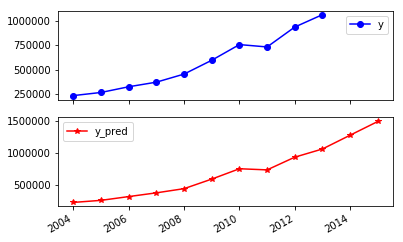

In [22]:
print('预测图为: ',data[['y','y_pred']].plot(subplots = True,style=['b-o','r-*'],xticks=data.index[::2]))

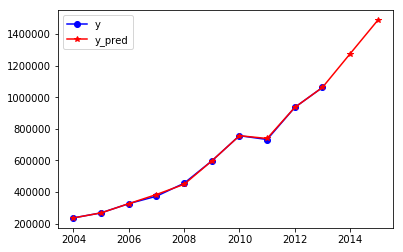

In [23]:
plt.plot(data['y'],'b-o')
plt.plot(data['y_pred'],'r-*')
plt.legend()
plt.show()